# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_nopercolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv2d_202', 'block8_10_conv', 'conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8153 - accuracy: 0.7296

947/947 [==============================] - 5647s 6s/step - loss: 0.8153 - accuracy: 0.7296 - val_loss: 1.0256 - val_accuracy: 0.7129
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.7589

947/947 [==============================] - 5218s 6s/step - loss: 0.7004 - accuracy: 0.7589 - val_loss: 0.7278 - val_accuracy: 0.7526
Epoch 3/200
947/947 [==============================] - 4847s 5s/step - loss: 0.6556 - accuracy: 0.7738 - val_loss: 0.8005 - val_accuracy: 0.7477
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.7836

947/947 [==============================] - 5206s 5s/step - loss: 0.6168 - accuracy: 0.7836 - val_loss: 0.6891 - val_accuracy: 0.7749
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.7934

947/947 [==============================] - 5251s 6s/step - loss: 0.5888 - accuracy: 0.7934 - val_loss: 0.6458 - val_accuracy: 0.7699
Epoch 6/200
947/947 [==============================] - 4826s 5s/step - loss: 0.5704 - accuracy: 0.8015 - val_loss: 0.6992 - val_accuracy: 0.7726
Epoch 7/200
947/947 [==============================] - 4827s 5s/step - loss: 0.5442 - accuracy: 0.8096 - val_loss: 25.8078 - val_accuracy: 0.0820
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5314 - accuracy: 0.8108

947/947 [==============================] - 5215s 6s/step - loss: 0.5314 - accuracy: 0.8108 - val_loss: 0.5767 - val_accuracy: 0.7957
Epoch 9/200
947/947 [==============================] - 4828s 5s/step - loss: 0.5067 - accuracy: 0.8194 - val_loss: 0.5825 - val_accuracy: 0.7946
Epoch 10/200
947/947 [==============================] - ETA: 0s - loss: 0.4902 - accuracy: 0.8261

947/947 [==============================] - 5214s 6s/step - loss: 0.4902 - accuracy: 0.8261 - val_loss: 0.5362 - val_accuracy: 0.8146
Epoch 11/200
947/947 [==============================] - 4830s 5s/step - loss: 0.4801 - accuracy: 0.8306 - val_loss: 0.5893 - val_accuracy: 0.7924
Epoch 12/200
947/947 [==============================] - 4830s 5s/step - loss: 0.4629 - accuracy: 0.8355 - val_loss: 0.6242 - val_accuracy: 0.7913
Epoch 13/200
947/947 [==============================] - 4831s 5s/step - loss: 0.4434 - accuracy: 0.8427 - val_loss: 0.5364 - val_accuracy: 0.8123
Epoch 14/200
947/947 [==============================] - ETA: 0s - loss: 0.4426 - accuracy: 0.8415

947/947 [==============================] - 5293s 6s/step - loss: 0.4426 - accuracy: 0.8415 - val_loss: 0.5009 - val_accuracy: 0.8246
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.4200 - accuracy: 0.8488

947/947 [==============================] - 5295s 6s/step - loss: 0.4200 - accuracy: 0.8488 - val_loss: 0.4903 - val_accuracy: 0.8317
Epoch 16/200
947/947 [==============================] - 4832s 5s/step - loss: 0.4017 - accuracy: 0.8557 - val_loss: 0.5580 - val_accuracy: 0.8054
Epoch 17/200
947/947 [==============================] - 4831s 5s/step - loss: 0.4037 - accuracy: 0.8552 - val_loss: 0.4959 - val_accuracy: 0.8287
Epoch 18/200
947/947 [==============================] - ETA: 0s - loss: 0.3807 - accuracy: 0.8605

947/947 [==============================] - 5224s 6s/step - loss: 0.3807 - accuracy: 0.8605 - val_loss: 0.4837 - val_accuracy: 0.8316
Epoch 19/200
947/947 [==============================] - 4828s 5s/step - loss: 0.3718 - accuracy: 0.8659 - val_loss: 0.5008 - val_accuracy: 0.8241
Epoch 20/200
947/947 [==============================] - 4829s 5s/step - loss: 0.3621 - accuracy: 0.8685 - val_loss: 0.4929 - val_accuracy: 0.8272
Epoch 21/200
947/947 [==============================] - 4832s 5s/step - loss: 0.3485 - accuracy: 0.8753 - val_loss: 0.4856 - val_accuracy: 0.8280
Epoch 22/200
947/947 [==============================] - 4830s 5s/step - loss: 0.3329 - accuracy: 0.8783 - val_loss: 0.5294 - val_accuracy: 0.8258
Epoch 23/200
947/947 [==============================] - 4832s 5s/step - loss: 0.3235 - accuracy: 0.8803 - val_loss: 0.4950 - val_accuracy: 0.8337
Epoch 24/200
947/947 [==============================] - ETA: 0s - loss: 0.3077 - accuracy: 0.8875

947/947 [==============================] - 5231s 6s/step - loss: 0.3077 - accuracy: 0.8875 - val_loss: 0.4717 - val_accuracy: 0.8431
Epoch 25/200
947/947 [==============================] - 4834s 5s/step - loss: 0.3011 - accuracy: 0.8899 - val_loss: 0.5065 - val_accuracy: 0.8353
Epoch 26/200
947/947 [==============================] - 4833s 5s/step - loss: 0.2868 - accuracy: 0.8947 - val_loss: 0.5119 - val_accuracy: 0.8354
Epoch 27/200
947/947 [==============================] - 4833s 5s/step - loss: 0.2758 - accuracy: 0.8981 - val_loss: 0.4879 - val_accuracy: 0.8336
Epoch 28/200
947/947 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.9023

947/947 [==============================] - 5218s 6s/step - loss: 0.2659 - accuracy: 0.9023 - val_loss: 0.4572 - val_accuracy: 0.8502
Epoch 29/200
947/947 [==============================] - 4932s 5s/step - loss: 0.2609 - accuracy: 0.9029 - val_loss: 0.4771 - val_accuracy: 0.8436
Epoch 30/200
947/947 [==============================] - 4925s 5s/step - loss: 0.2456 - accuracy: 0.9085 - val_loss: 0.4858 - val_accuracy: 0.8432
Epoch 31/200
947/947 [==============================] - 4919s 5s/step - loss: 0.2341 - accuracy: 0.9139 - val_loss: 0.4757 - val_accuracy: 0.8486
Epoch 32/200
947/947 [==============================] - 4910s 5s/step - loss: 0.2303 - accuracy: 0.9150 - val_loss: 0.4907 - val_accuracy: 0.8459
Epoch 33/200
947/947 [==============================] - 4930s 5s/step - loss: 0.2228 - accuracy: 0.9184 - val_loss: 0.5406 - val_accuracy: 0.8324
Epoch 34/200
947/947 [==============================] - 4830s 5s/step - loss: 0.2112 - accuracy: 0.9236 - val_loss: 0.5525 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 535s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9769619938855005,
 'basal cell carcinoma': 0.9887594247959579,
 'dermatofibroma': 0.983577993640284,
 'melanoma': 0.9413522313733002,
 'nevus': 0.9688568633910762,
 'pigmented benign keratosis': 0.9873943240064793,
 'seborrheic keratosis': 0.9645937906674102,
 'solar lentigo': 0.9689637147710938,
 'squamous cell carcinoma': 0.9855203118945379,
 'vascular lesion': 0.999773107236685}

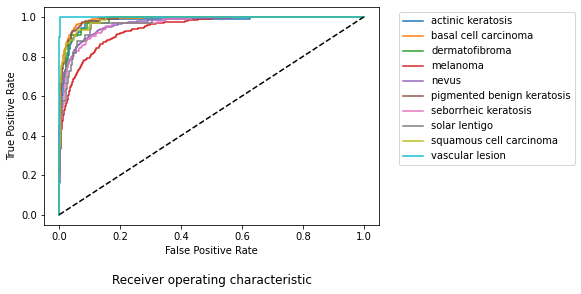

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

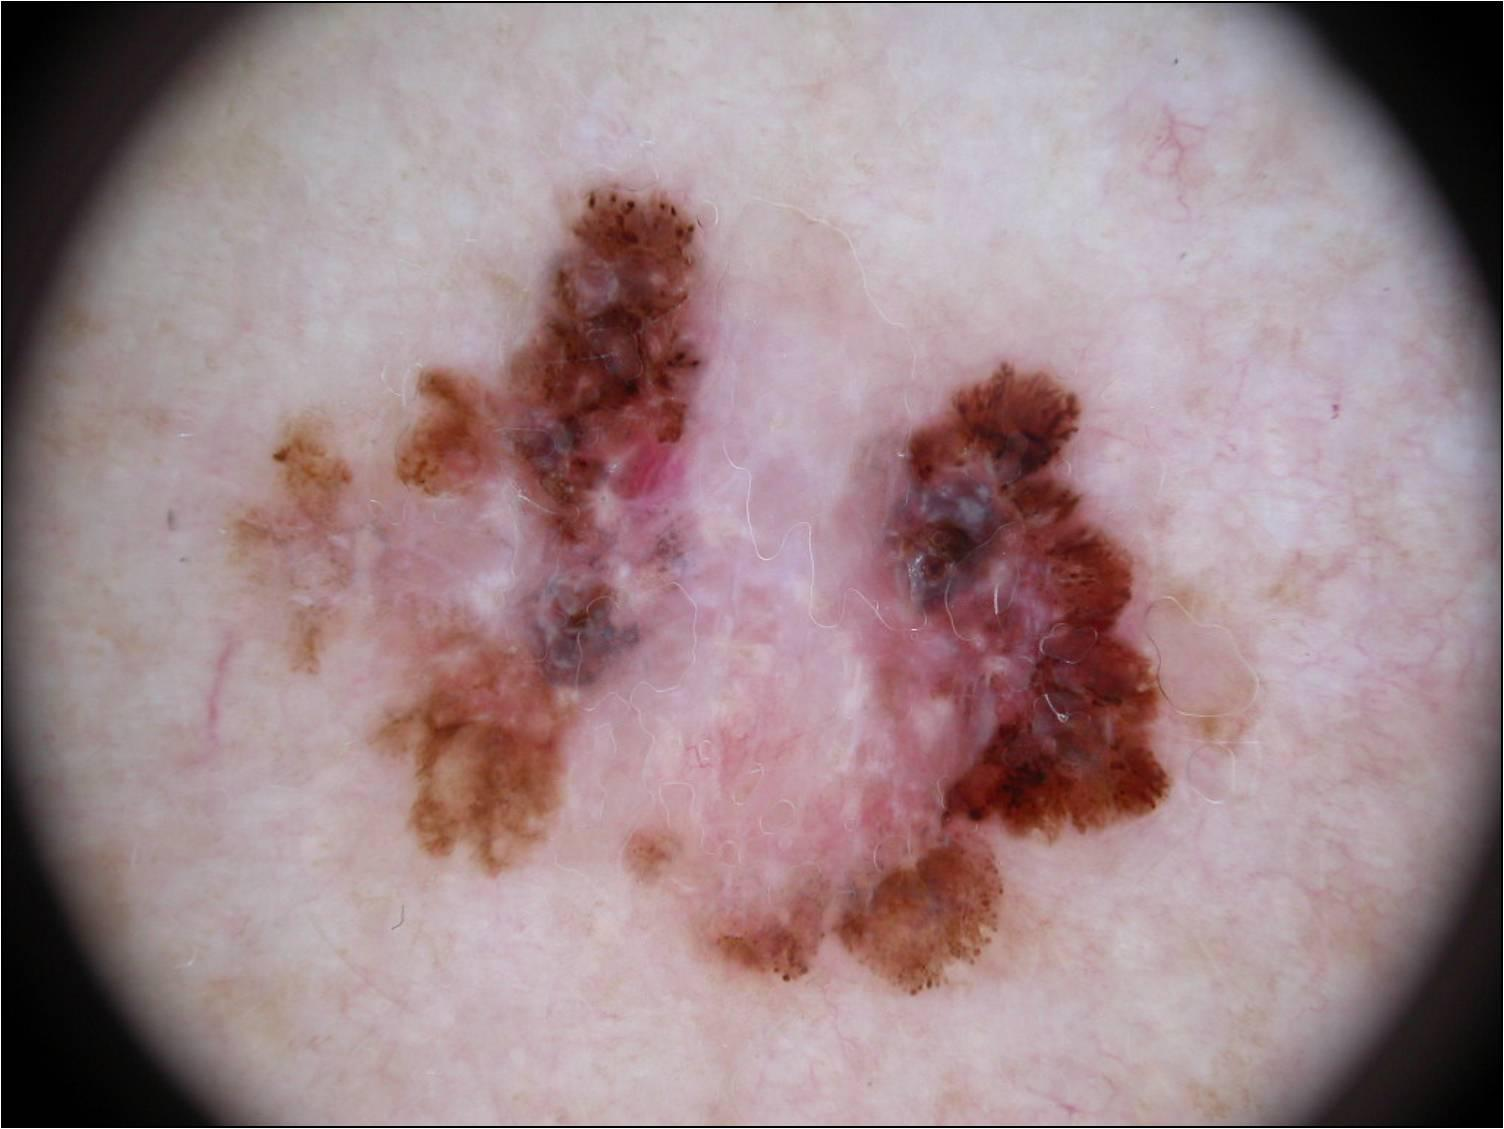

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'conv_7b')

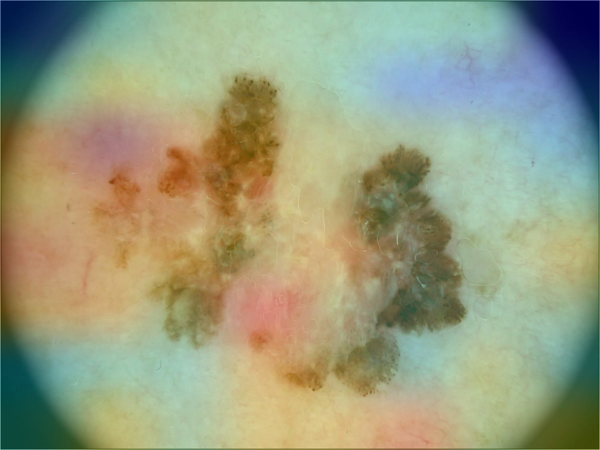

In [23]:
display_gradcam(melanoma_im_path, heatmap)